In [1]:
from tools import vis, util

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Structured Data Walkthrough
This shows you each step you need to visualize structured data using dimension reduction and glyph visualization. The cell at the end puts it all together and runs this analysis on additional datasets.

# Load the data
All structured datasets have an X and a y, and can be loaded with the *util.load_dataset* command.

This gets you X, a dataframe, with labeled columns, and y, the labels, which is a series whose index matches X>

In [2]:
X, y = util.load_dataset('./processed/iris.json')

There are 4 features in this dataset

In [3]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


There are 3 classes, and 50 examples in each class

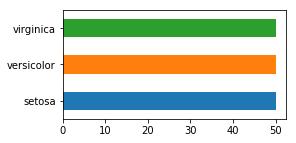

In [4]:
plt.figure(figsize=(4,2))
y.value_counts().sort_index().plot.barh()

We can visualize structured data using a radar glyph. We need to noramlize the dimensions first.

In [5]:
from sklearn.preprocessing import MinMaxScaler

X_norm = pd.DataFrame(MinMaxScaler().fit_transform(X), index=X.index, columns=X.columns)

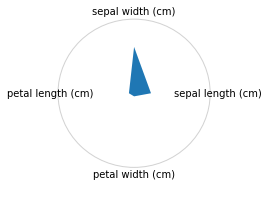

In [6]:
import imp
imp.reload(vis)

plt.figure(figsize=(3,3))
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axis('off')


vis.radar_plot(X_norm.iloc[:1].values, labels=X.columns);

If we want to visualize multiple things for comparison, we'll want to adjust the appearance slightly

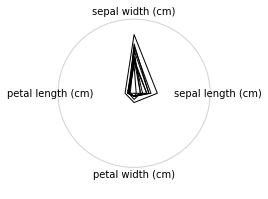

In [7]:
plt.figure(figsize=(3,3))
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axis('off')

vis.radar_plot(X_norm.iloc[:10].values,
               facecolors='none',
               linewidths=1,
               labels=X.columns
              );

For such a small dataset, we could actually show all the data, colored by class to see how it is distribured across the features.

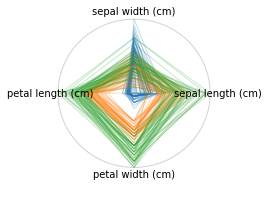

In [8]:
#setup a color palette
colors = {k: plt.cm.tab10(i) for i, k in enumerate(y.unique())}

plt.figure(figsize=(3,3))
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axis('off')

vis.radar_plot(X_norm.values,
               alpha=.25,
               edgecolors=y.apply(colors.get),
               facecolors='none',
               linewidths=1,
               labels=X.columns
              );

# Dimension Reduction
Let's apply PCA to understand the data in 2-D. This builds a pipeline to normalize the data and apply PCA. The result is stored in *pos*, a DataFrame with the same index as the original data.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pos = pd.DataFrame(Pipeline([
    ('norm', StandardScaler()),
    ('proj', PCA(n_components=2))
]).fit_transform(X), index=X.index)

pos.head()

,0,1
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477
3,-2.304197,-0.575368
4,-2.388777,0.674767


# Scatter plot
This shows the projected data and their coresponding class. We can see that PCA has helped separate the data into classes. However, this visualization doesn't help you see what features in the original data are important.

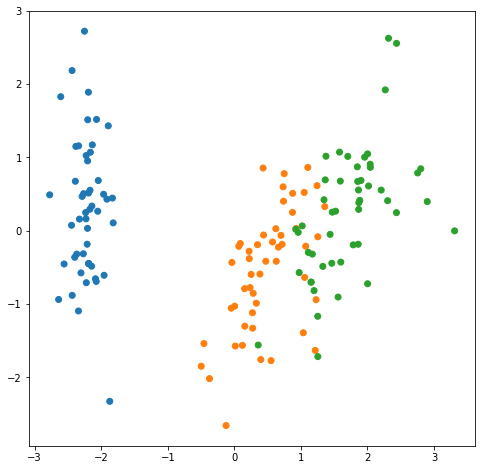

In [10]:
plt.figure(figsize=(8,8))

plt.scatter(*pos.values.T, c=y.apply(colors.get))

# Combined Dimension Reduction & Glyph Plot
We can improve the above plot by drawing a glyph for each point. The generator **vis.subplots_scatter** takes a list of points and gives you a set of indices and an axis to loop over. The axes are guaranteed not to overplot, and the indices are sorted by closeness to the center of the axis. This function allows you to combine multiple nearby instances into the same visualization, which makes comparison easier.

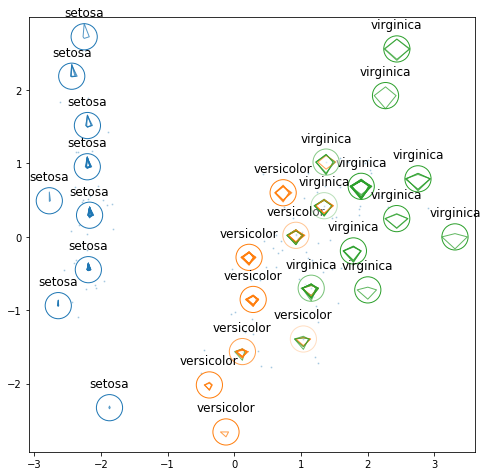

In [11]:
plt.figure(figsize=(8,8))

for x, ax in vis.subplots_scatter(pos,
                                  s=.05, # the size of the sub-plots, i.e, .05 means each plot takes 5% of the figure width
                                  scatter_args=dict(s=1, alpha=.25) # arguments for the scatter plot
                                 ):

    # determine the color and purity of each group based on classes
    counts = y.loc[x].value_counts()
    c = counts.idxmax()
    p = counts[c]/counts.sum()

    # make a radar plot of the features
    vis.radar_plot(X_norm.loc[x].values, ax=ax,
                   alpha=.75,
                   edgecolors=[colors[i] for i in y.loc[x]],
                   facecolors='none',
                   linewidths=1,
                   circle_props=dict(edgecolor=colors[c], linewidth=1, facecolor='white', alpha=p**2),
                  )

    plt.title(c)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.axis('off')

# Additional Datasets
This applies the basic steps from above to produce a similar visualization for any structured dataset. This also uses **vis.get_feature_order** to figure out a good ordering of features in the radar chart, which improves the usability of the visualization.

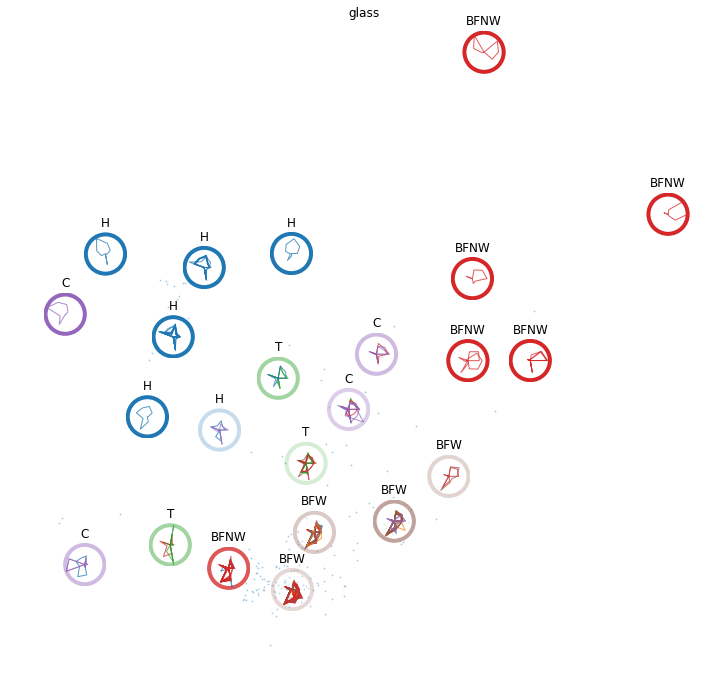

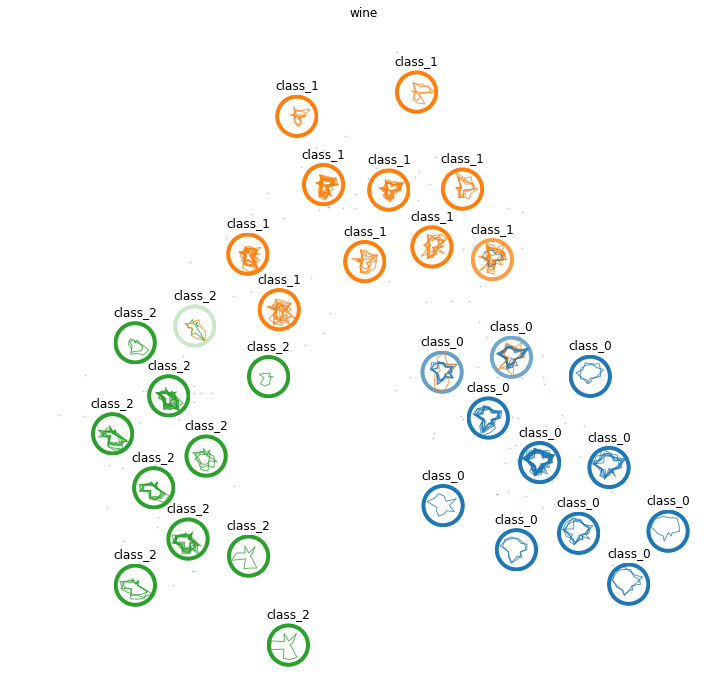

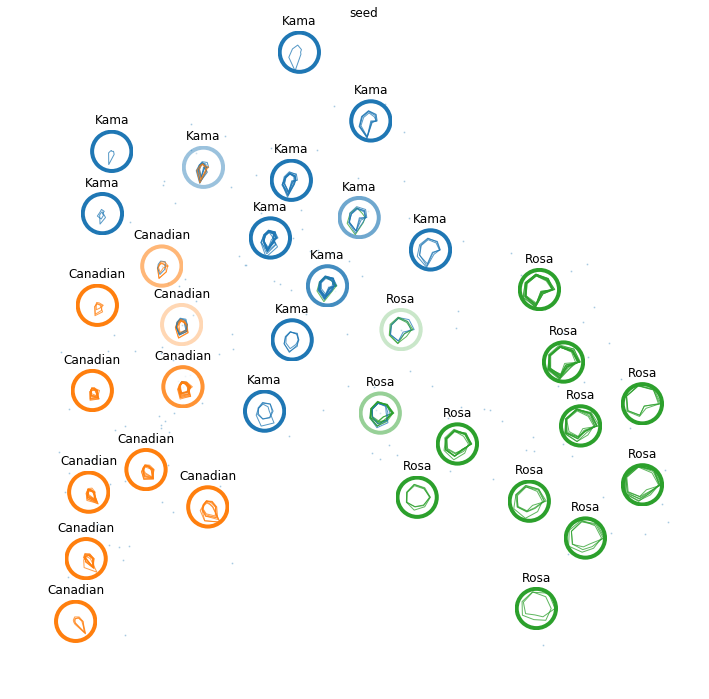

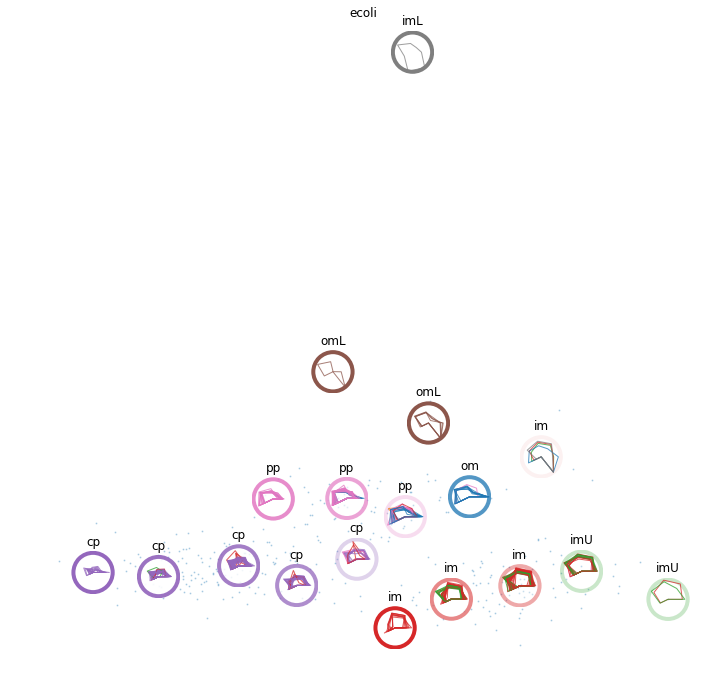

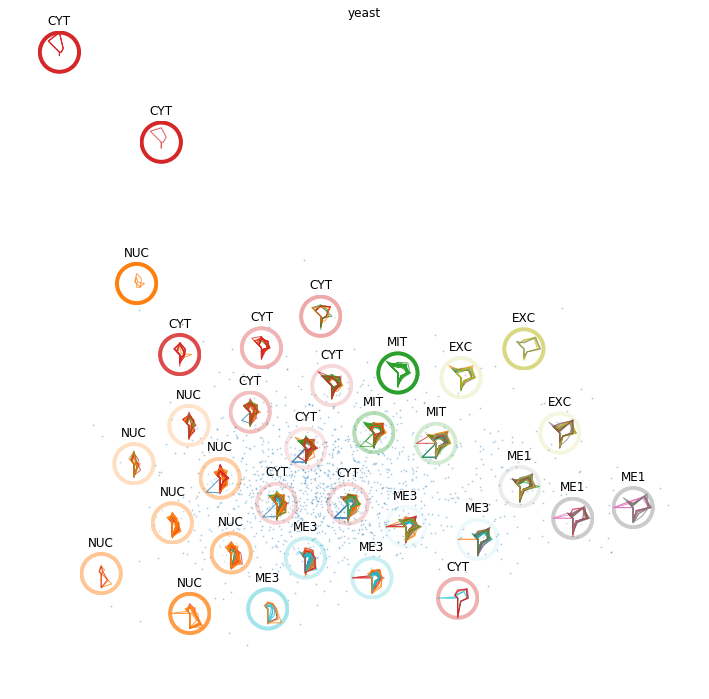

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

def low_d_structured_plot(X, y, **kwargs):
    
    # scale the columns between 0 and 1 using min-max scaler
    X_norm = pd.DataFrame(MinMaxScaler().fit_transform(X), index=X.index, columns=X.columns)
    
    # arrange columns so that correlated features are placed nearby
    order = vis.get_feature_order(X_norm)

    colors = {v: plt.cm.tab10(i) for i,v in enumerate(set(y))}

    # get the 2-D position by z-score normalizing and using PCA
    pos = pd.DataFrame(Pipeline([
        ('norm', StandardScaler()),
        ('proj', PCA(n_components=2))
    ]).fit_transform(X), index=X.index)

    for x, ax in vis.subplots_scatter(pos, scatter_args=dict(s=1, alpha=.25), **kwargs):
        
        # determine the color and purity of each group based on classes
        counts = y.loc[x].value_counts()
        c = counts.idxmax()
        p = counts[c]/counts.sum()

        # make a radar plot of the features
        vis.radar_plot(X_norm.loc[x, order].values, ax=ax,
                       alpha=.75,
                       edgecolors=[colors[i] for i in y.loc[x]],
                       facecolors='none',
                       linewidths=1,
                       circle_props=dict(edgecolor=colors[c], linewidth=4, facecolor='white', alpha=p**2)
                      )

        plt.title(c)
        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
        plt.axis('off')

        
datasets = [
    './processed/glass.json',
    './processed/wine.json',
    './processed/seed.json',
    './processed/ecoli.json',
    './processed/yeast.json'
]

for name in datasets:
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.title(os.path.splitext(os.path.basename(name))[0])
    low_d_structured_plot(*util.load_dataset(name))